Using device: cuda


Normalizing test/nofire: 100%|██████████| 251/251 [00:08<00:00, 28.23img/s]


Original mean: tensor([0.4145, 0.4044, 0.3784])
Original std: tensor([0.2285, 0.2066, 0.2088])
Normalized mean: tensor([-0.3080, -0.2301, -0.1227])
Normalized std: tensor([0.9978, 0.9223, 0.9282])


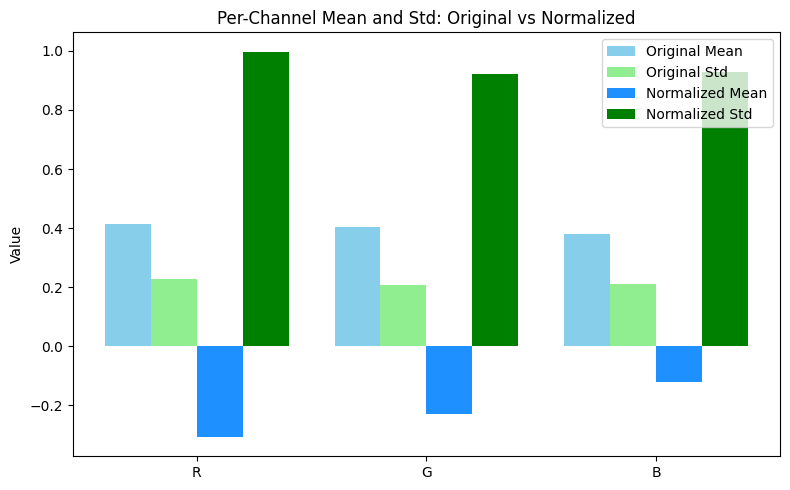

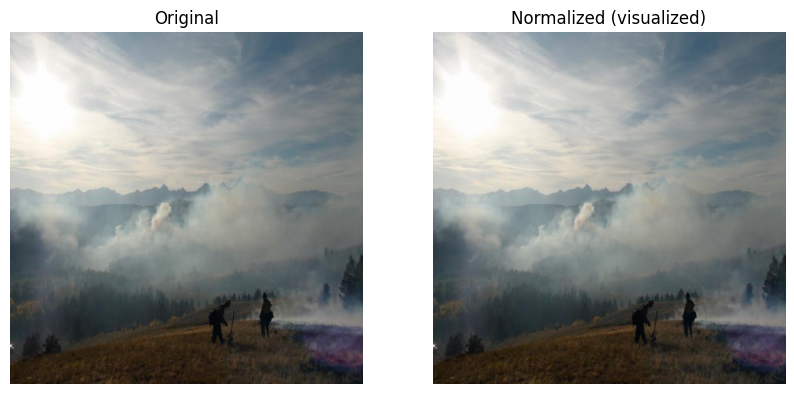

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# CONFIG
# -----------------------------
base_dir = 'E:\\SLIIT\\Year 2 Semester 1\\IT2011 - Artficial Intelligence and Machine Learning\\Assignment\\WildFireDetection\\results\\outputs\\resized'
output_dir = 'E:\\SLIIT\\Year 2 Semester 1\\IT2011 - Artficial Intelligence and Machine Learning\\Assignment\\WildFireDetection\\results\\outputs\\normalized'
splits = ['train', 'val', 'test']
classes = ['fire', 'nofire']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transform: convert to tensor + normalize
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

to_tensor = transforms.ToTensor()

# -----------------------------
# Stats containers
# -----------------------------
means_original = []
stds_original = []
means_normalized = []
stds_normalized = []

# -----------------------------
# NORMALIZATION PROCESSING
# -----------------------------
for split in splits:
    for cls in classes:
        input_path = os.path.join(base_dir, split, cls)
        output_path = os.path.join(output_dir, split, cls)
        os.makedirs(output_path, exist_ok=True)

        img_files = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
        for img_name in tqdm(img_files, desc=f"Normalizing {split}/{cls}", unit="img"):
            try:
                img = Image.open(os.path.join(input_path, img_name)).convert("RGB")
                
                # Compute original stats
                img_tensor = to_tensor(img)
                means_original.append(img_tensor.mean(dim=(1,2)).cpu())
                stds_original.append(img_tensor.std(dim=(1,2)).cpu())

                # Normalize
                img_norm = normalize_transform(img).to(device)
                means_normalized.append(img_norm.mean(dim=(1,2)).cpu())
                stds_normalized.append(img_norm.std(dim=(1,2)).cpu())

                # Save normalized image (reversed for visualization)
                img_save = img_norm * torch.tensor([0.229,0.224,0.225], device=device).view(3,1,1) + \
                           torch.tensor([0.485,0.456,0.406], device=device).view(3,1,1)
                img_save = img_save.clamp(0,1)
                img_save = to_pil_image(img_save.cpu())
                img_save.save(os.path.join(output_path, img_name))
                
            except Exception as e:
                tqdm.write(f" Error processing {img_name}: {e}")

# -----------------------------
# DATASET-WIDE STATS
# -----------------------------
means_original = torch.stack(means_original)
stds_original = torch.stack(stds_original)
means_normalized = torch.stack(means_normalized)
stds_normalized = torch.stack(stds_normalized)

mean_orig = means_original.mean(0)
std_orig = stds_original.mean(0)
mean_norm = means_normalized.mean(0)
std_norm = stds_normalized.mean(0)

print("Original mean:", mean_orig)
print("Original std:", std_orig)
print("Normalized mean:", mean_norm)
print("Normalized std:", std_norm)

# -----------------------------
# EDA: Mean/Std comparison bar chart
# -----------------------------
channels = ['R','G','B']
x = np.arange(len(channels))
width = 0.2

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width, mean_orig.numpy(), width, label='Original Mean', color='skyblue')
ax.bar(x, std_orig.numpy(), width, label='Original Std', color='lightgreen')
ax.bar(x + width, mean_norm.numpy(), width, label='Normalized Mean', color='dodgerblue')
ax.bar(x + 2*width, std_norm.numpy(), width, label='Normalized Std', color='green')

ax.set_xticks(x + width/2)
ax.set_xticklabels(channels)
ax.set_ylabel('Value')
ax.set_title('Per-Channel Mean and Std: Original vs Normalized')
ax.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# SAMPLE IMAGE VISUALIZATION
# -----------------------------
sample_path = os.path.join(base_dir, 'train', 'fire', os.listdir(os.path.join(base_dir, 'train','fire'))[0])
img = Image.open(sample_path).convert("RGB")
img_tensor = to_tensor(img)
img_norm = normalize_transform(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
img_vis = img_norm * torch.tensor([0.229,0.224,0.225], device=img_norm.device).view(3,1,1) + \
          torch.tensor([0.485,0.456,0.406], device=img_norm.device).view(3,1,1)
img_vis = img_vis.clamp(0,1)
plt.imshow(to_pil_image(img_vis.cpu()))
plt.title('Normalized (visualized)')
plt.axis('off')
plt.show()
